# Section 0

# Librares

In [1]:
import numpy as np
import pandas as pd
import random
import os
import shutil
import cv2 
import skimage #OTSU
import matplotlib.pyplot as plt
import tarfile

In [2]:
from PIL import Image
from keras import backend as K
import sklearn
import keras
import tensorflow as tf


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
from scipy import ndimage as ndi

# Engine

In [4]:
print(tf.__version__)
print(keras.__version__)
!nvidia-smi

2.13.0
2.13.1
Wed Jan 10 12:43:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+-----------

In [5]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.experimental.set_memory_growth(physical_devices[1], True)

Number of devices: 2


# Metrics

In [6]:
#intersection over union
def iou(y_true, y_pred, smooth = 0.5):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Define Dice coefficient metric
def dice_coefficient(y_true, y_pred, epsilon=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    dice_score = (2.0 * intersection + epsilon) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + epsilon)
    return dice_score

def jaccard_coefficient(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1) - intersection
    jaccard = (intersection + K.epsilon()) / (union + K.epsilon())
    return jaccard

def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)

def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

In [7]:
def confusion_matrix_img(y_pred, y_true, savename):
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    labels = ['NOT tumor', 'NECROTIC/CORE','EDEMA','ENHANCING']
    title='Confusion matrix'
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(savename)
    plt.show()

In [8]:
def count_flops(layer):
    num_params = layer.count_params()
    layer_type = layer.__class__.__name__

    if "Conv2D" in layer_type:
        # Assuming each convolutional operation requires (2 * kernel_size - 1) FLOPs
        kernel_size = layer.kernel_size[0] * layer.kernel_size[1]
        flops_per_op = (2 * kernel_size - 1) * layer.filters
    elif "Dense" in layer_type:
        # Assuming each dense layer operation requires 2 FLOPs
        flops_per_op = 2
    else:
        # For other layers, a simple assumption
        flops_per_op = 1

    return num_params * flops_per_op


# CallBacks

In [9]:
epochs = 20

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=epochs,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = tf.keras.callbacks.CSVLogger('Model.log')

# Define a learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)


callbacks = [earlystop, csv_logger, reduce_lr]

# Section 1

# Dataset

In [10]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',   
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE - RED
    2 : 'EDEMA',  # Green
    3 : 'ENHANCING' # original 4 -> converted into 3 later, Yellow
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

IMG_SIZE=128


In [11]:
file = tarfile.open('../input/brats-2021-task1/BraTS2021_Training_Data.tar')

file.extractall('./BraTS2021_Training_Data')
file.close()

file = tarfile.open('../input/brats-2021-task1/BraTS2021_00621.tar')

file.extractall('./sample_img')
file.close()

nSample = os.listdir('./sample_img')
nSample

['BraTS2021_00621_t1.nii.gz',
 'BraTS2021_00621_seg.nii.gz',
 'BraTS2021_00621_t2.nii.gz',
 'BraTS2021_00621_flair.nii.gz',
 'BraTS2021_00621_t1ce.nii.gz']

In [12]:
TRAIN_DATASET_PATH = './BraTS2021_Training_Data/'

In [13]:
nSample = os.listdir(TRAIN_DATASET_PATH + 'BraTS2021_01261')
nSample

['BraTS2021_01261_seg.nii.gz',
 'BraTS2021_01261_flair.nii.gz',
 'BraTS2021_01261_t1.nii.gz',
 'BraTS2021_01261_t1ce.nii.gz',
 'BraTS2021_01261_t2.nii.gz']

In [14]:
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_flair.nii.gz').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_t1.nii.gz').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_t1ce.nii.gz').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_t2.nii.gz').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_seg.nii.gz').get_fdata()

Text(0.5, 1.0, 'Mask')

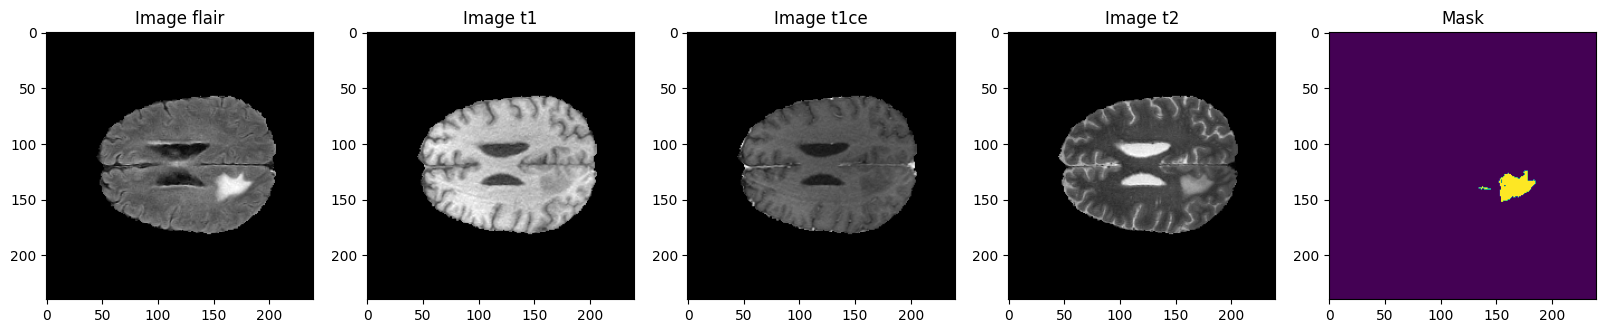

In [15]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

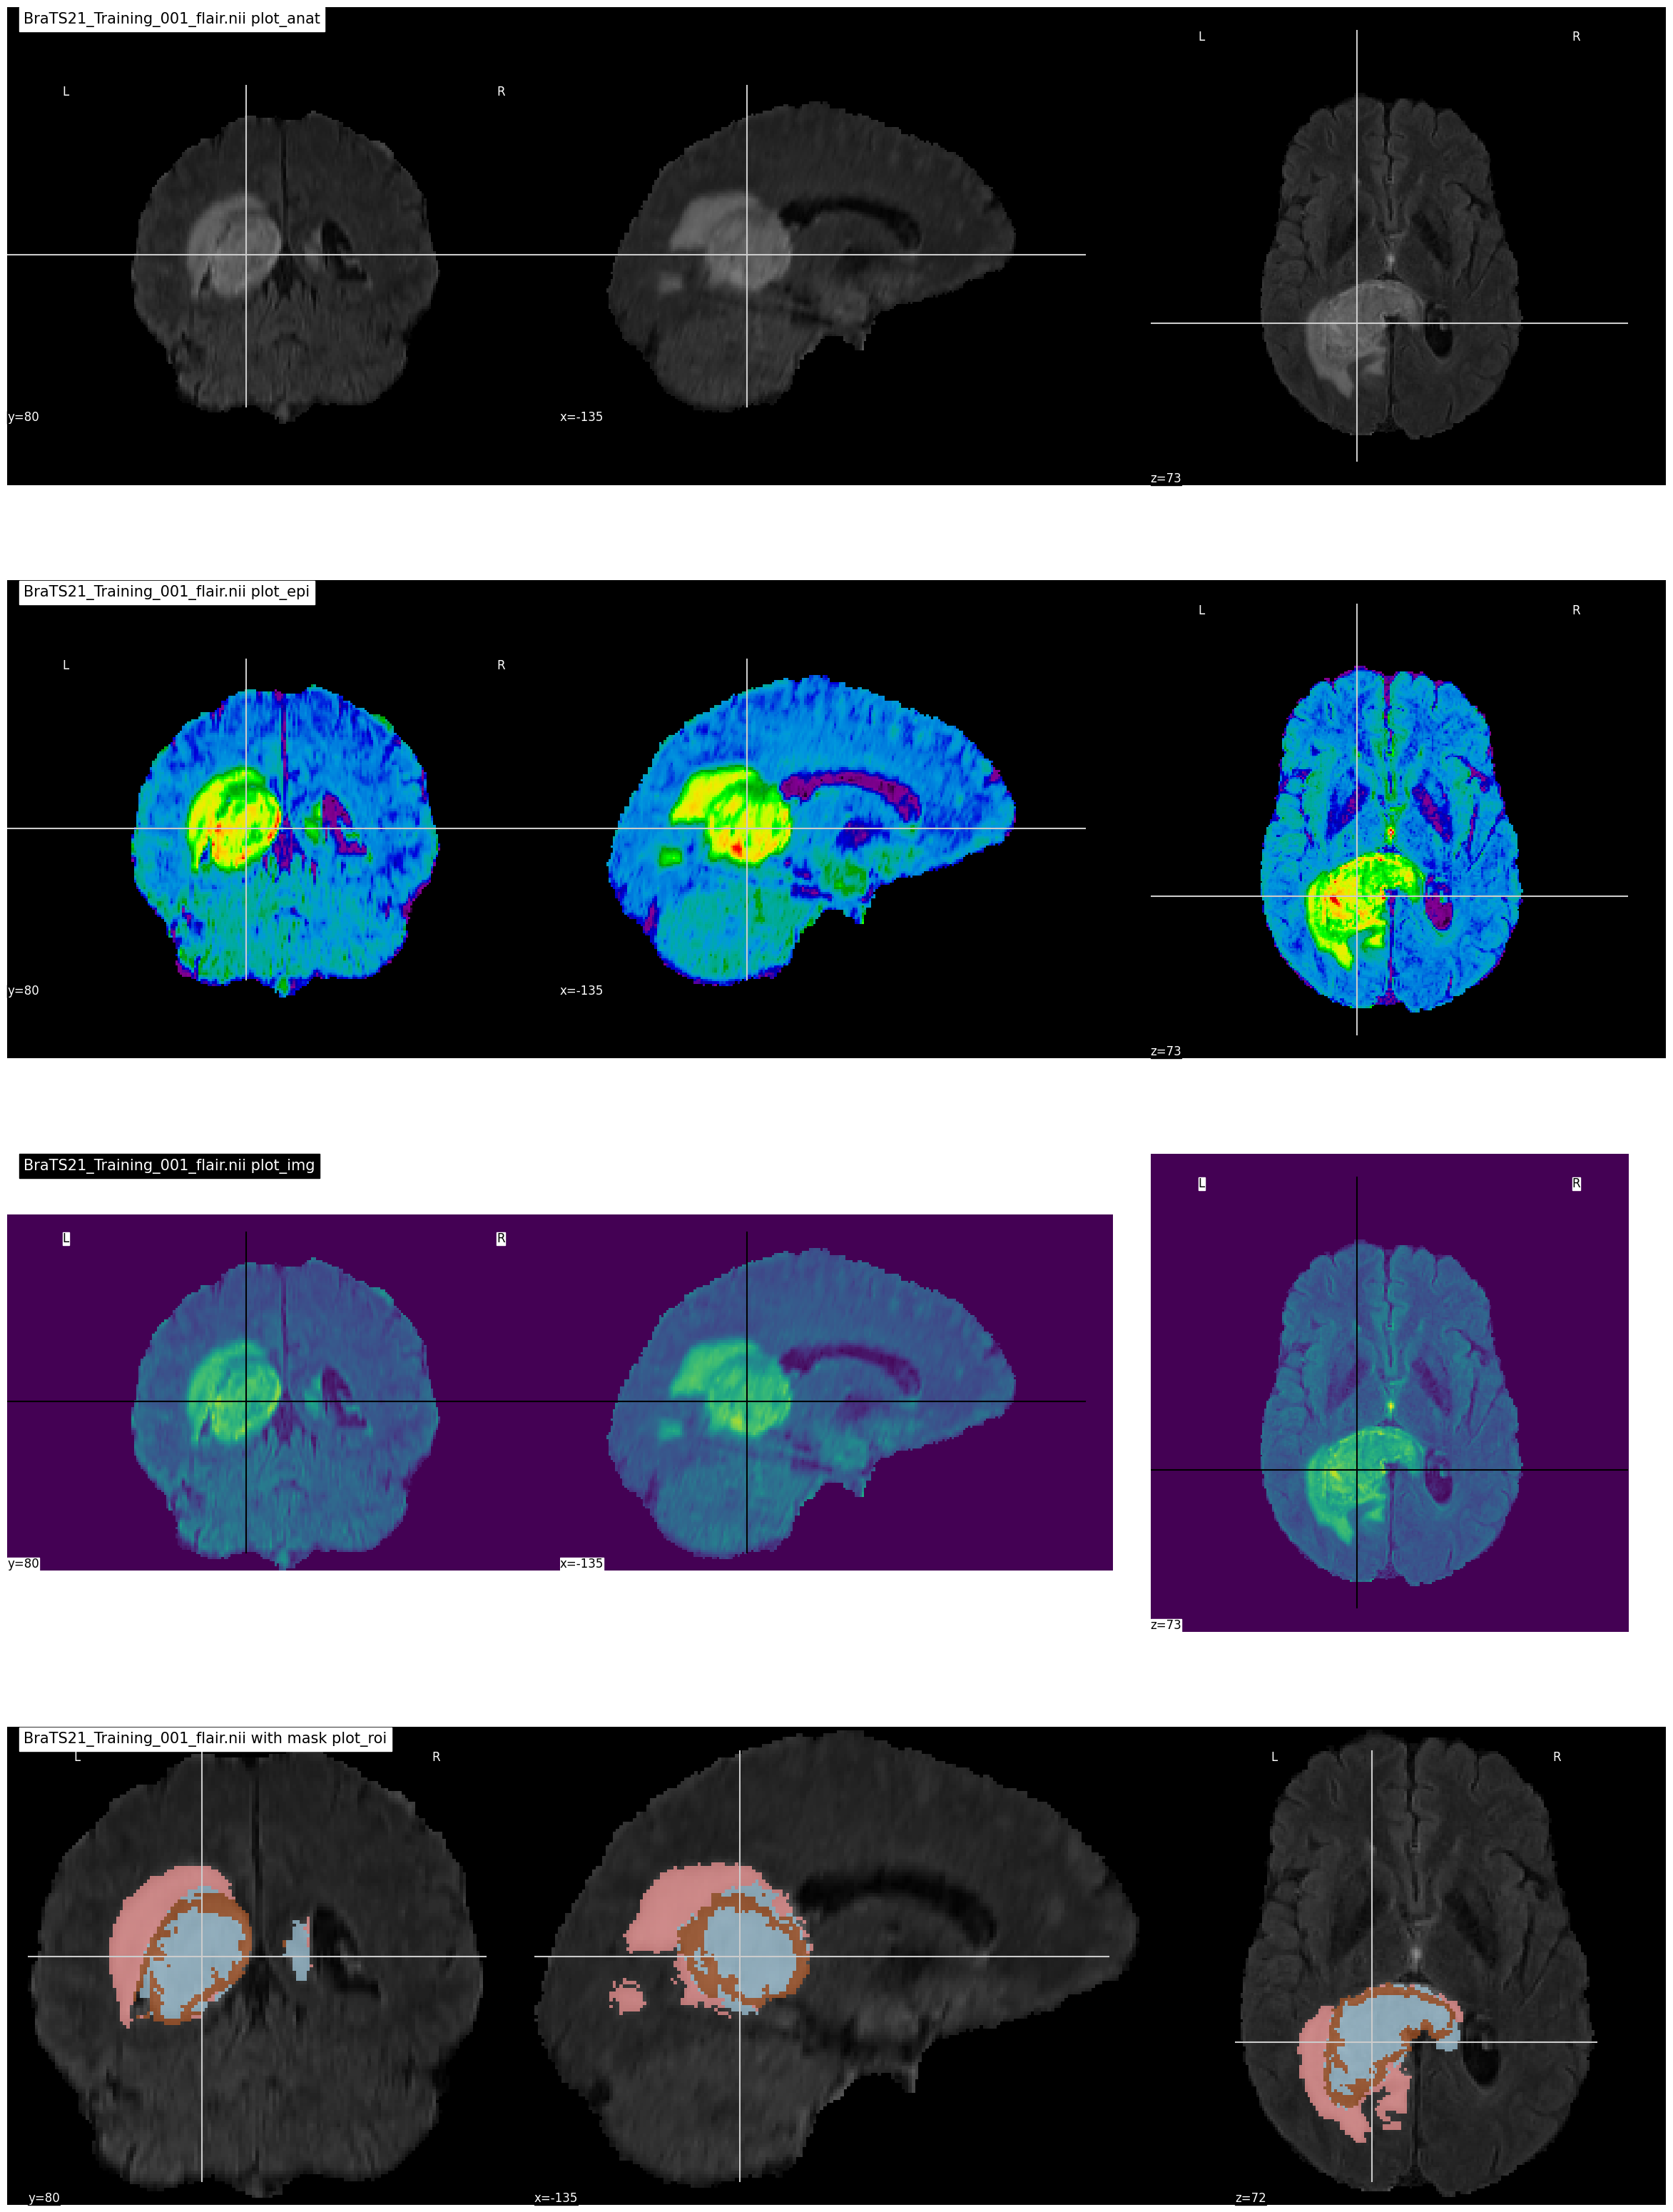

In [16]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_flair.nii.gz')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_seg.nii.gz')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS21_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS21_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS21_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS21_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [17]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = sklearn.model_selection.train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = sklearn.model_selection.train_test_split(train_test_ids,test_size=0.15) 

# Section 2

# DataGenerator & Preprocessing

# With tensorflow-Augment And OTSU Thresholding

In [18]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]

        # Find list of IDs
        batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)


    def __data_generation(self, batch_ids):
        'Generates data containing batch_size samples' # X: (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4))

        # Generate data
        for c, i in enumerate(batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz')
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz')
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii.gz')
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]

        # Normalize input data
        X_normalized = (X - np.mean(X)) / np.std(X)
        
        # Convert labels to one-hot encoding
        y[y == 4] = 3
        mask = tf.one_hot(y, 4)
        mask_resized = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        
        # Apply Otsu thresholding to segmentation masks
        otsu_thresholds = np.zeros((self.batch_size * VOLUME_SLICES, 4))
        for i in range(mask_resized.shape[0]):
            for class_idx in range(4):
                otsu_thresholds[i, class_idx] = skimage.filters.threshold_otsu(mask_resized[i, :, :, class_idx].numpy())

        # Reshape otsu_thresholds to match the shape of mask_resized
        otsu_thresholds_reshaped = otsu_thresholds.reshape((self.batch_size * VOLUME_SLICES, 1, 1, 4))
        #otsu_thresholds_reshaped = otsu_thresholds.reshape((self.batch_size * VOLUME_SLICES, 1, 1, 2, 4))
        #otsu_thresholds_reshaped = otsu_thresholds.reshape((self.batch_size * VOLUME_SLICES, 2, 4))
        #otsu_thresholds_reshaped = otsu_thresholds.reshape((self.batch_size * VOLUME_SLICES, 4, 2))
        

        # Binarize masks using Otsu thresholds
        binarized_masks = (mask_resized >= otsu_thresholds_reshaped)
        
        # Apply data augmentation on-the-fly
        augmented_images = []
        augmented_masks = []
        
        for i in range(X_normalized.shape[0]):
            #augmented_images.append(tf.image.random_flip_left_right(X_normalized[i]))
            #augmented_masks.append(tf.image.random_flip_left_right(mask_resized[i]))
            
            
            augmented_images.append(tf.image.random_brightness(X_normalized[i], 0.2))
            augmented_masks.append(tf.image.random_brightness(mask_resized[i], 0.2))
            
            augmented_images.append(tf.image.random_contrast(X_normalized[i], 0.2, 0.5))
            augmented_masks.append(tf.image.random_contrast(mask_resized[i], 0.2, 0.5))

        
        augmented_images = tf.stack(augmented_images)
        augmented_masks = tf.stack(augmented_masks)

        return augmented_images, augmented_masks

# Create instances of the DataGenerator class
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

850
251
150


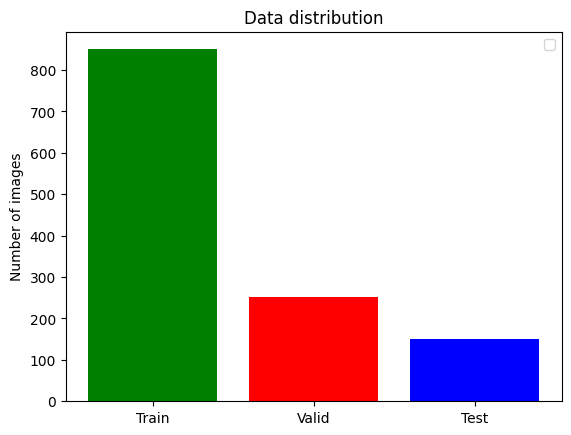

In [19]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')
    plt.savefig('data2018.png')
    plt.show()

print(len(train_ids))
print(len(val_ids))
print(len(test_ids))
showDataLayout()

# Section 3

# Model

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

In [21]:
def unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Middle
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)

    # Decoder
    up4 = concatenate([UpSampling2D(size=(2, 2))(conv3), conv2], axis=-1)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(up4)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)

    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv1], axis=-1)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

    outputs = Conv2D(4, (1, 1), activation='sigmoid')(conv5)

    model = Model(inputs=inputs, outputs=outputs)

    return model


In [22]:
%%time
input_shape = (IMG_SIZE, IMG_SIZE, 2)  # Adjust the number of channels according to the data

with strategy.scope():
    model = unet(input_shape)
    model.compile(loss = "categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule, 
                                           beta_1 = 0.9, 
                                           beta_2 = 0.999, 
                                           epsilon = 1e-07, 
                                           clipnorm = 0.5,
                                           clipvalue=0.5,
                                           global_clipnorm=None,
                                           weight_decay=1e-5), 
              
            metrics = (['accuracy', tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='AUC'),
                        f1_score, specificity, sensitivity, iou, dice_coefficient, jaccard_coefficient]))

print(model.input_shape)
print(model.output_shape)
model.summary()
total_flops = sum(count_flops(layer) for layer in model.layers)
print(f"Estimated FLOPs: {total_flops / 1e9} G")

(None, 128, 128, 2)
(None, 128, 128, 4)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 2)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1216      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                   

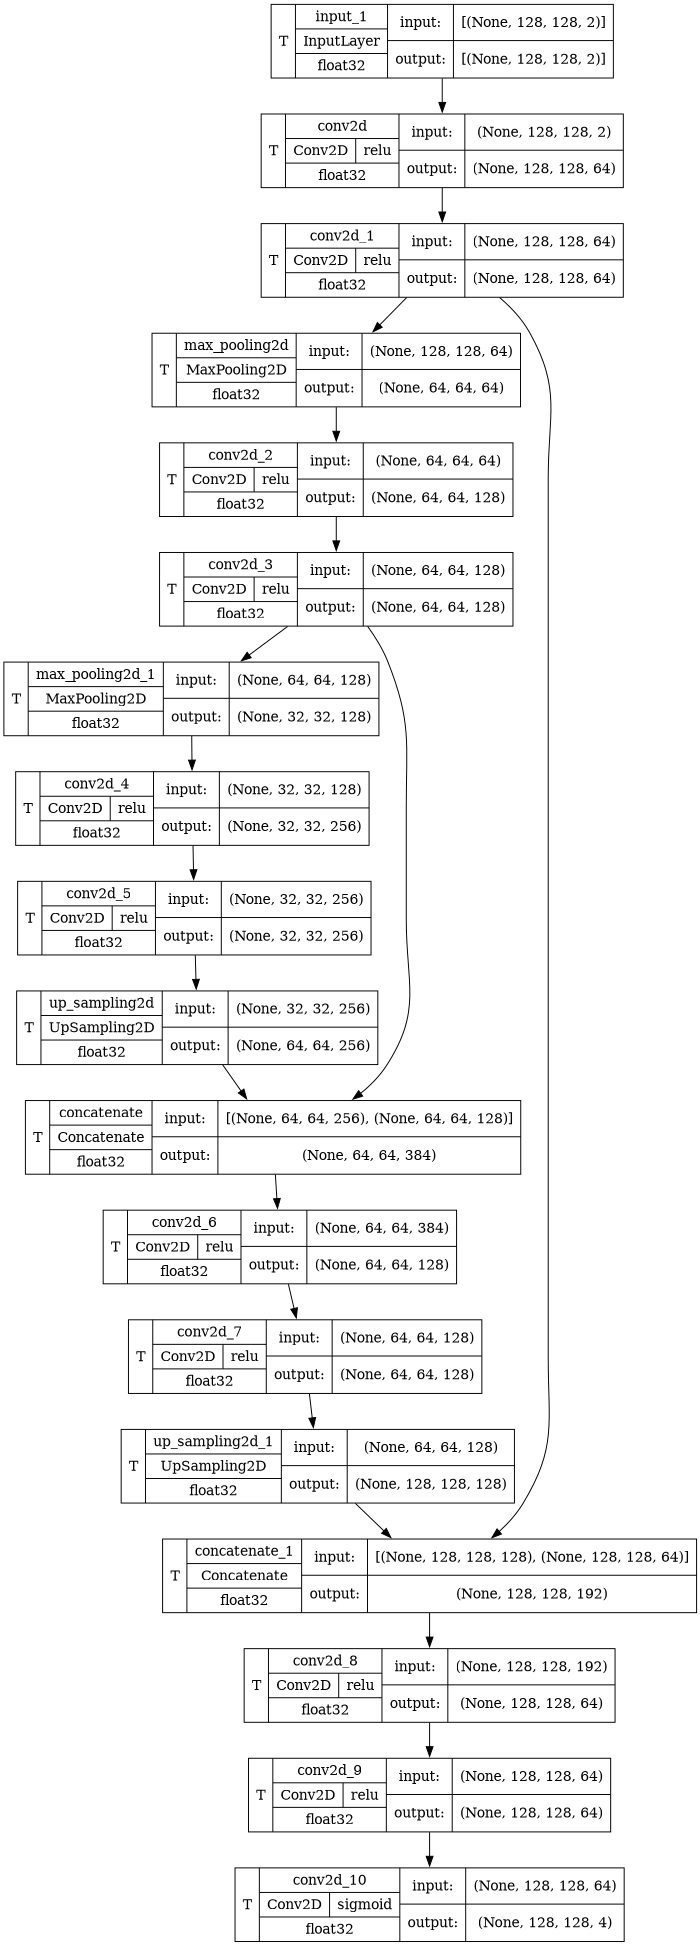

In [23]:
tf.keras.utils.plot_model(model, 
           show_shapes = True,
           show_dtype= True,
           show_layer_names = True,
           show_layer_activations= True,
           show_trainable= True,
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

# Train 

In [24]:
%%time
BATCH_SIZE = 16
history =  model.fit(training_generator,
                        epochs = 20,
                        steps_per_epoch=len(train_ids)//BATCH_SIZE,
                        validation_data = valid_generator,
                        validation_steps=len(val_ids)//BATCH_SIZE,
                        callbacks = callbacks) 

Epoch 1/20
53/53 [==============================] - 171s 3s/step - loss: 0.1534 - accuracy: 0.9910 - precision: 0.8592 - recall: 0.6568 - AUC: 0.6801 - f1_score: 0.5913 - specificity: 0.5251 - sensitivity: 0.9858 - iou: 0.4239 - dice_coefficient: 0.5906 - jaccard_coefficient: 0.4728 - val_loss: 0.0616 - val_accuracy: 0.9918 - val_precision: 0.9062 - val_recall: 0.5006 - val_AUC: 0.6728 - val_f1_score: 0.7229 - val_specificity: 0.7597 - val_sensitivity: 0.9927 - val_iou: 0.5746 - val_dice_coefficient: 0.7297 - val_jaccard_coefficient: 0.6240 - lr: 0.0010
Epoch 2/20
53/53 [==============================] - 134s 3s/step - loss: 0.1218 - accuracy: 0.9910 - precision: 0.9850 - recall: 0.3441 - AUC: 0.6717 - f1_score: 0.9511 - specificity: 0.9511 - sensitivity: 0.9920 - iou: 0.6007 - dice_coefficient: 0.7488 - jaccard_coefficient: 0.6547 - val_loss: 0.0604 - val_accuracy: 0.9923 - val_precision: 0.8852 - val_recall: 0.5701 - val_AUC: 0.6748 - val_f1_score: 0.6632 - val_specificity: 0.6668 - 

# Section 4

In [25]:
model.save("Model.h5")
print('Model save to Disk')

Model save to Disk


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Result

In [26]:
import pandas as pd
df = pd.DataFrame(history.history) 
df.to_excel("output.xlsx")
#df.to_csv("output.csv")
df.head(30)

loss  accuracy  precision    recall       AUC  f1_score  specificity  \
0   0.153388  0.991041   0.859215  0.656805  0.680092  0.591334     0.525056   
1   0.121789  0.991026   0.984999  0.344148  0.671703  0.951073     0.951097   
2   0.096668  0.991078   0.901723  0.547857  0.687154  0.691470     0.697798   
3   0.090692  0.990677   0.905734  0.569279  0.699142  0.664272     0.662915   
4   0.053686  0.992142   0.899164  0.553896  0.700160  0.682912     0.680292   
5   0.035788  0.990869   0.969594  0.353364  0.667268  0.924115     0.928319   
6   0.077009  0.991614   1.000000  0.318156  0.641978  0.988013     0.993191   
7   0.127308  0.991319   0.972526  0.368340  0.631049  0.922684     0.929021   
8   0.099641  0.992130   0.904180  0.554765  0.663133  0.678853     0.686070   
9   0.068113  0.990758   0.882857  0.631762  0.696250  0.615171     0.564804   
10  0.116885  0.990765   0.908447  0.520583  0.681282  0.712087     0.710895   
11  0.092529  0.989630   0.864510  0.748222  0.706082  0.527332     0.400710   
12  0.060689  0.991418   0.907738  0.530857  0.687387  0.713638     0.707646   
13  0.087514  0.990889   0.943624  0.426036  0.668950  0.814532     0.837162   
14  0.109233  0.991403   0.900447  0.580874  0.704118  0.657300     0.644648   
15  0.105444  0.989915   0.850799  0.788662  0.726412  0.510772     0.325731   
16  0.052521  0.991435   0.803895  0.892317  0.740413  0.447147     0.157175   
17  0.056324  0.992232   0.922387  0.486620  0.685650  0.757125     0.746360   
18  0.083830  0.992498   0.911407  0.487572  0.668684  0.746224     0.761512   
19  0.070077  0.992321   0.902219  0.563366  0.675036  0.669101     0.676680   

    sensitivity       iou  dice_coefficient  ...  val_precision  val_recall  \
0      0.985765  0.423868          0.590645  ...       0.906217    0.500616   
1      0.991987  0.600696          0.748843  ...       0.885182    0.570090   
2      0.994766  0.503060          0.668945  ...       0.891509    0.571276   
3      0.995062  0.444117          0.614845  ...       0.897062    0.564156   
4      0.996219  0.443966          0.614462  ...       0.943958    0.409858   
5      0.992462  0.640673          0.775919  ...       1.000000    0.319385   
6      0.991595  0.827670          0.904465  ...       1.000000    0.305827   
7      0.992277  0.719686          0.832516  ...       0.884856    0.538648   
8      0.996058  0.469761          0.637981  ...       0.895940    0.575153   
9      0.996450  0.406149          0.576034  ...       0.898218    0.560582   
10     0.995076  0.467147          0.634774  ...       0.876134    0.694101   
11     0.996357  0.356150          0.524796  ...       0.883676    0.688120   
12     0.996027  0.462868          0.631588  ...       0.957539    0.450464   
13     0.994442  0.488459          0.656206  ...       0.892088    0.454569   
14     0.996542  0.434475          0.605239  ...       0.795240    0.882250   
15     0.996815  0.350501          0.518450  ...       0.790983    0.925664   
16     0.997995  0.324162          0.488786  ...       0.829393    0.764160   
17     0.996261  0.455863          0.625481  ...       0.965047    0.380787   
18     0.996649  0.474957          0.643741  ...       0.886965    0.566361   
19     0.996458  0.456678          0.626851  ...       0.906548    0.553428   

     val_AUC  val_f1_score  val_specificity  val_sensitivity   val_iou  \
0   0.672799      0.722934         0.759697         0.992662  0.574614   
1   0.674835      0.663192         0.666792         0.994811  0.465606   
2   0.686319      0.664074         0.664728         0.996215  0.447452   
3   0.683051      0.665112         0.666415         0.996015  0.436650   
4   0.698618      0.845966         0.839795         0.994217  0.504218   
5   0.629396      0.991859         0.992541         0.993351  0.795141   
6   0.604448      0.986390         0.993921         0.987456  0.829988   
7   0.653982      0.686392         0.696905         0.993942  0.525069   
8

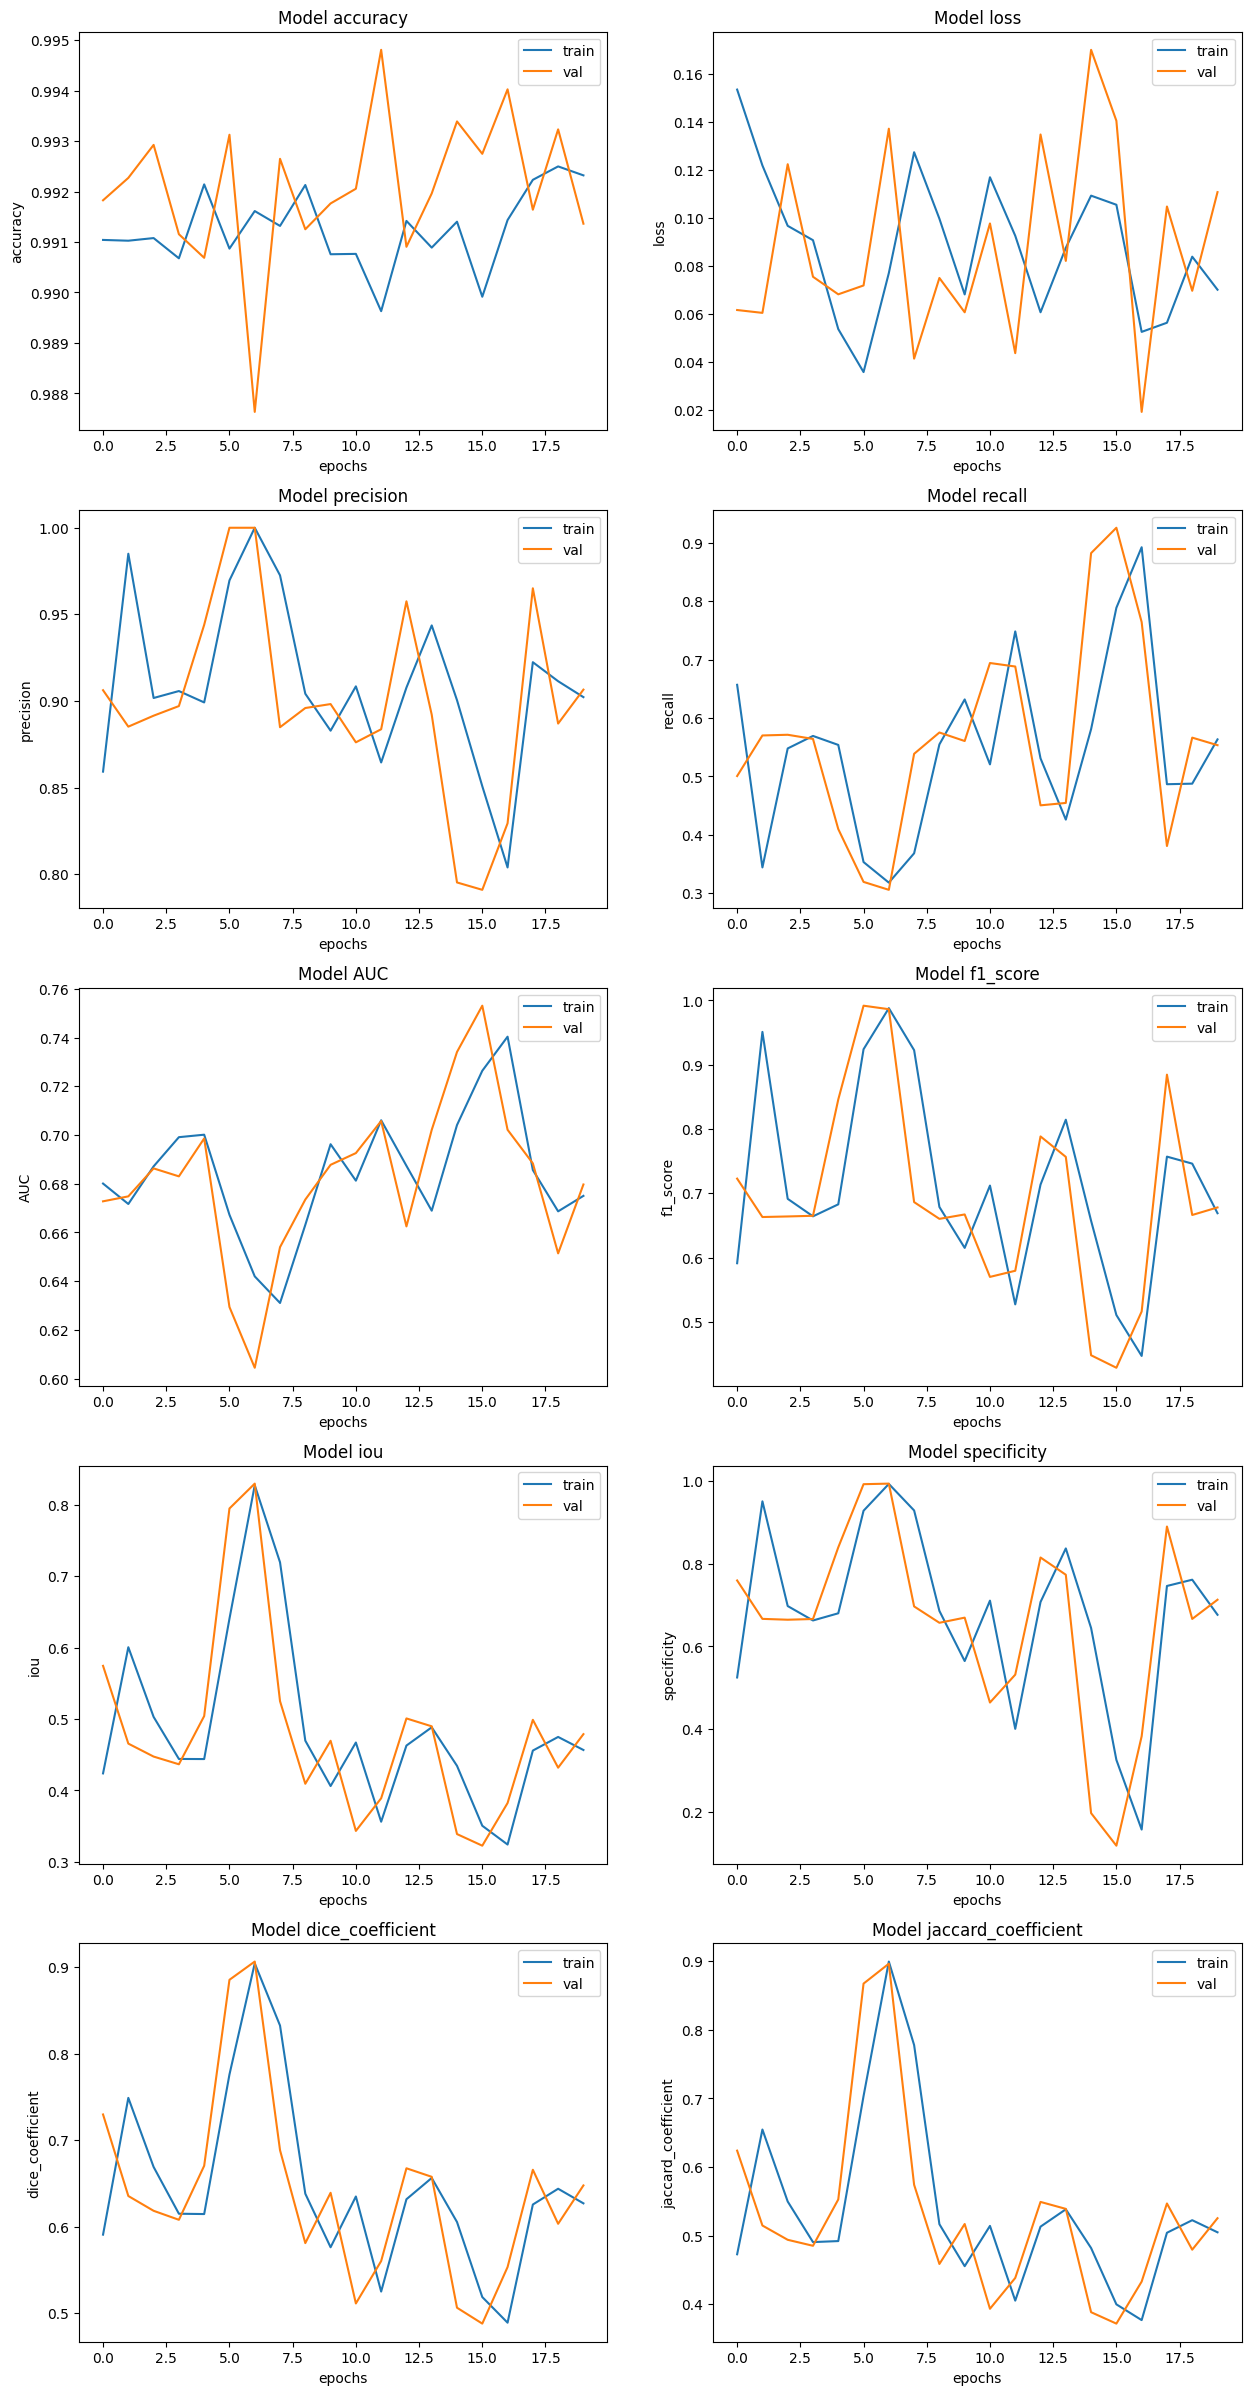

In [27]:
# Interpreting the Metrics
fig, ax = plt.subplots(5, 2, figsize=(15, 30))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss', 'precision', 'recall', 'AUC','f1_score', 'iou','specificity','dice_coefficient', 'jaccard_coefficient' ]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig("Model-Results.png")

In [28]:
%%time
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size = 16, callbacks = callbacks)
print("test loss, test acc:", results)

Evaluate on test data
150/150 [==============================] - 228s 2s/step - loss: 0.0612 - accuracy: 0.9922 - precision: 0.8994 - recall: 0.5499 - AUC: 0.6725 - f1_score: 0.6791 - specificity: 0.7149 - sensitivity: 0.9970 - iou: 0.4784 - dice_coefficient: 0.6472 - jaccard_coefficient: 0.5266
test loss, test acc: [0.061234649270772934, 0.9921939969062805, 0.8993973135948181, 0.5499268770217896, 0.6725091934204102, 0.6790703535079956, 0.7149378657341003, 0.9969635009765625, 0.47841256856918335, 0.6471596360206604, 0.5265883207321167]
CPU times: user 3min 37s, sys: 38.6 s, total: 4min 15s
Wall time: 3min 49s


4/4 [==============================] - 3s 226ms/step


<Figure size 1800x5000 with 0 Axes>

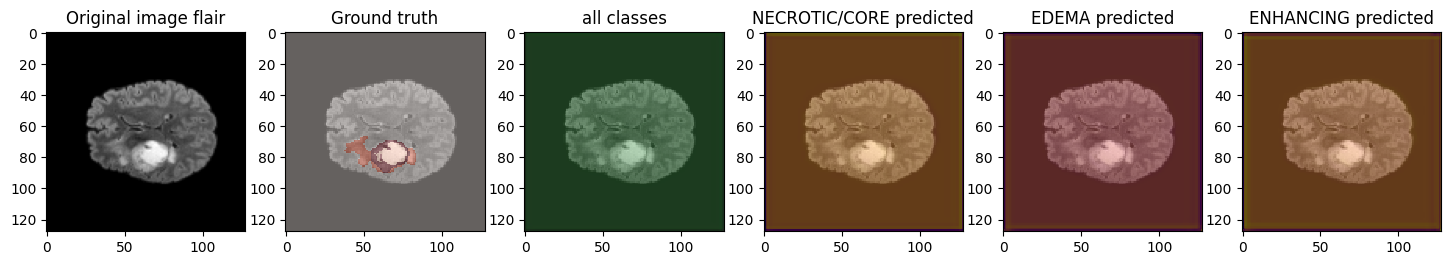

4/4 [==============================] - 0s 52ms/step


<Figure size 1800x5000 with 0 Axes>

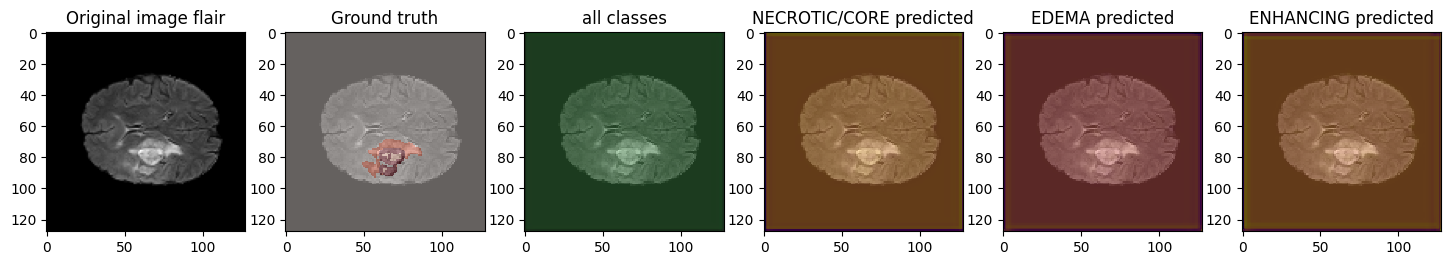

4/4 [==============================] - 0s 58ms/step


<Figure size 1800x5000 with 0 Axes>

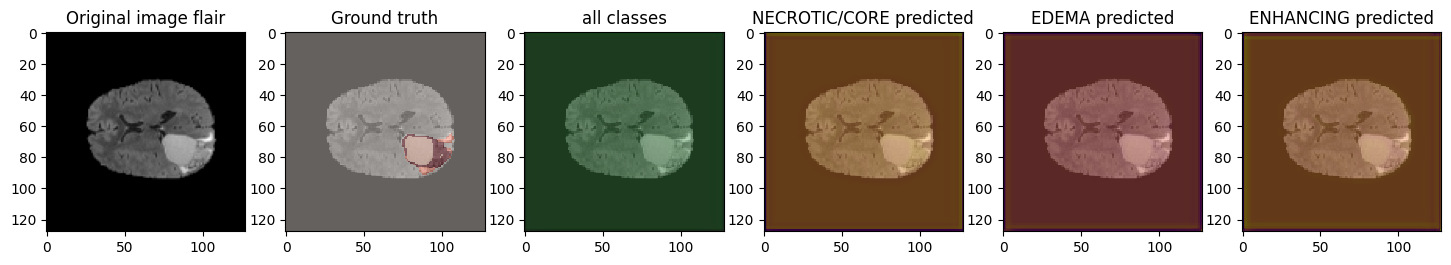

4/4 [==============================] - 0s 45ms/step


<Figure size 1800x5000 with 0 Axes>

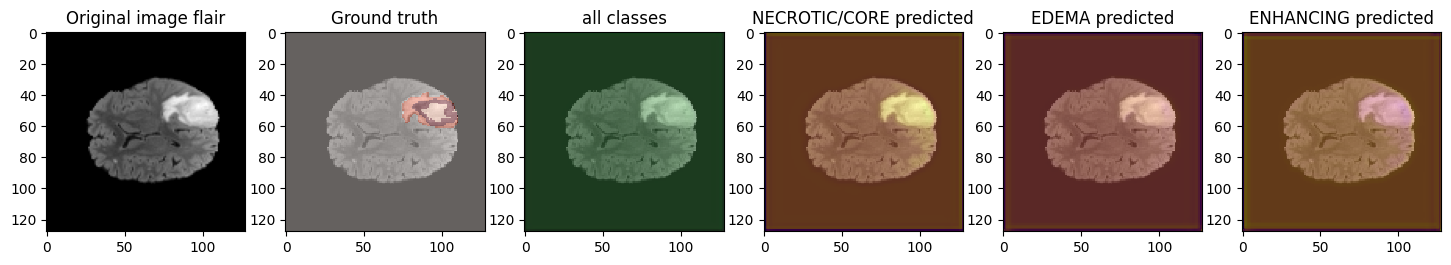

4/4 [==============================] - 0s 61ms/step


<Figure size 1800x5000 with 0 Axes>

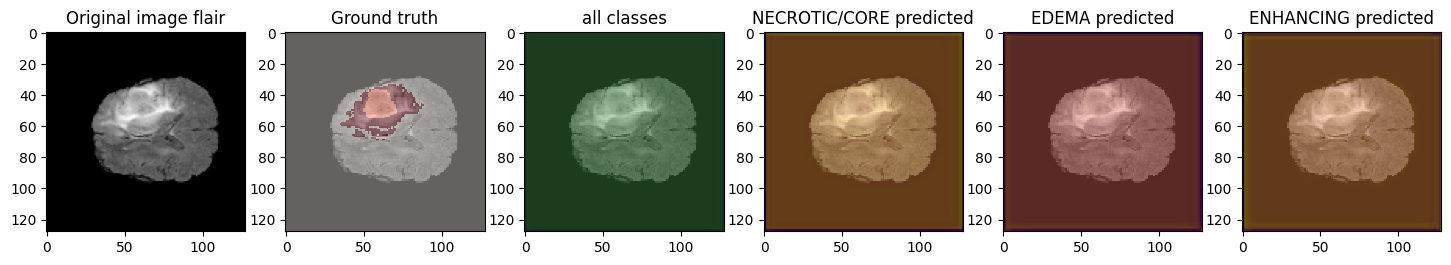

4/4 [==============================] - 0s 61ms/step


<Figure size 1800x5000 with 0 Axes>

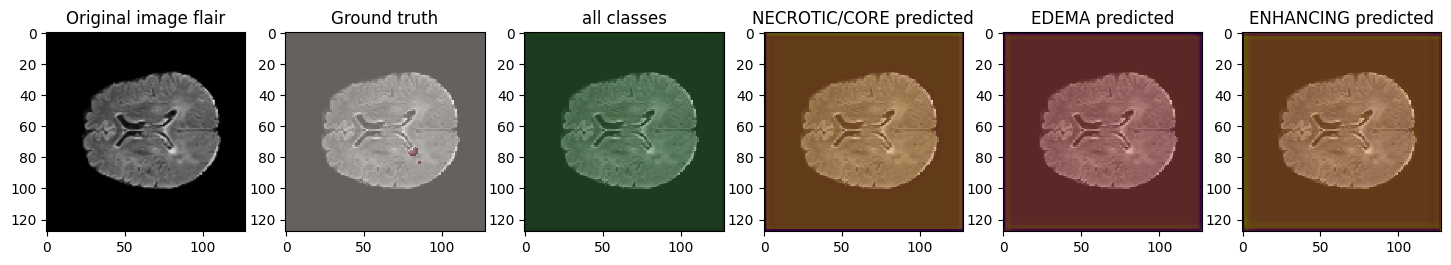

4/4 [==============================] - 0s 59ms/step


<Figure size 1800x5000 with 0 Axes>

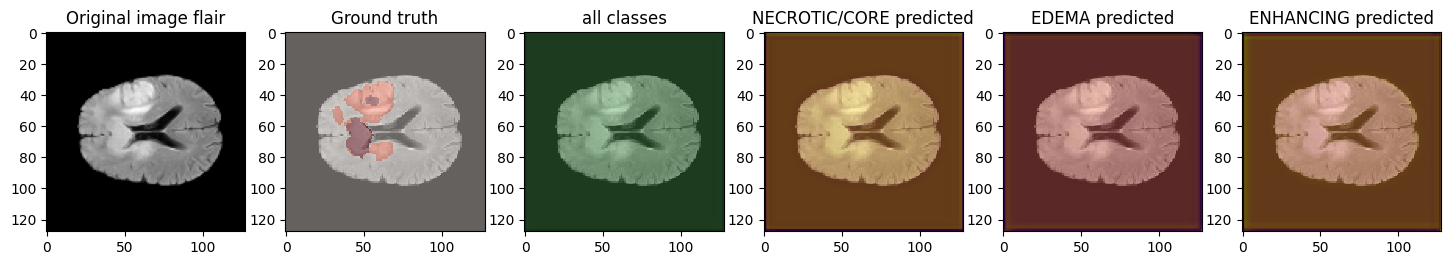

4/4 [==============================] - 0s 59ms/step


<Figure size 1800x5000 with 0 Axes>

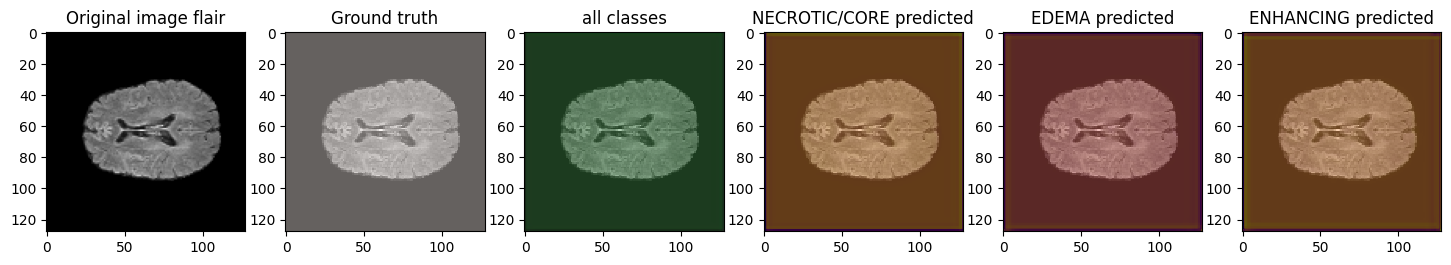

4/4 [==============================] - 0s 58ms/step


<Figure size 1800x5000 with 0 Axes>

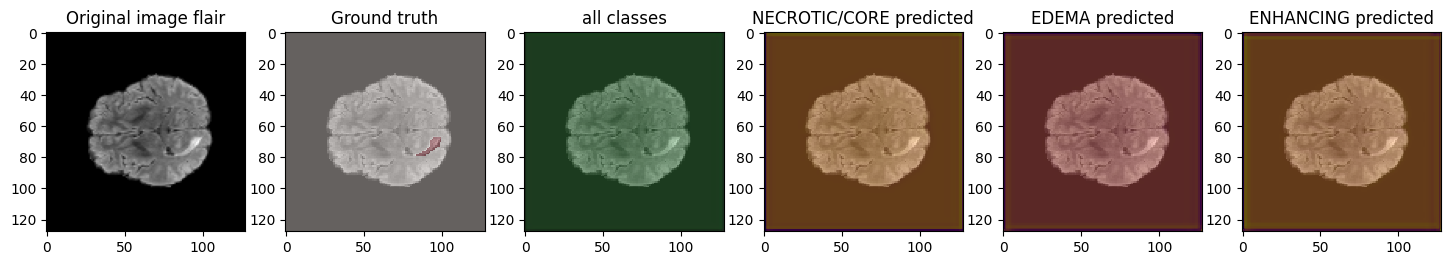

4/4 [==============================] - 0s 61ms/step


<Figure size 1800x5000 with 0 Axes>

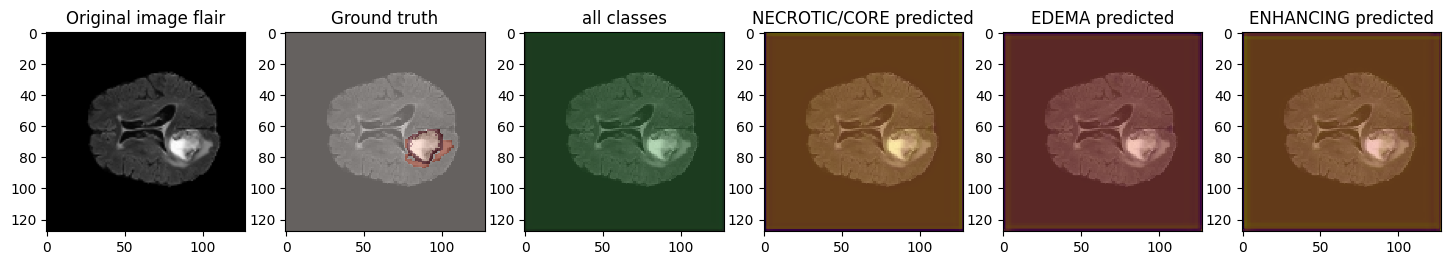

4/4 [==============================] - 0s 44ms/step


<Figure size 1800x5000 with 0 Axes>

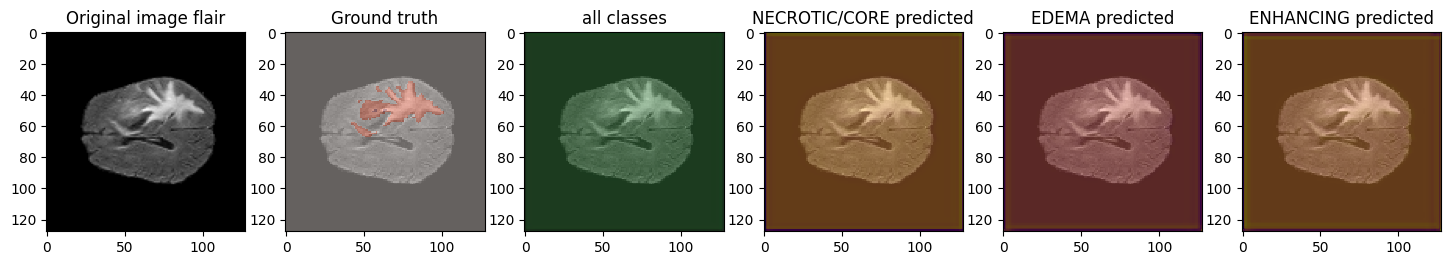

4/4 [==============================] - 0s 43ms/step


<Figure size 1800x5000 with 0 Axes>

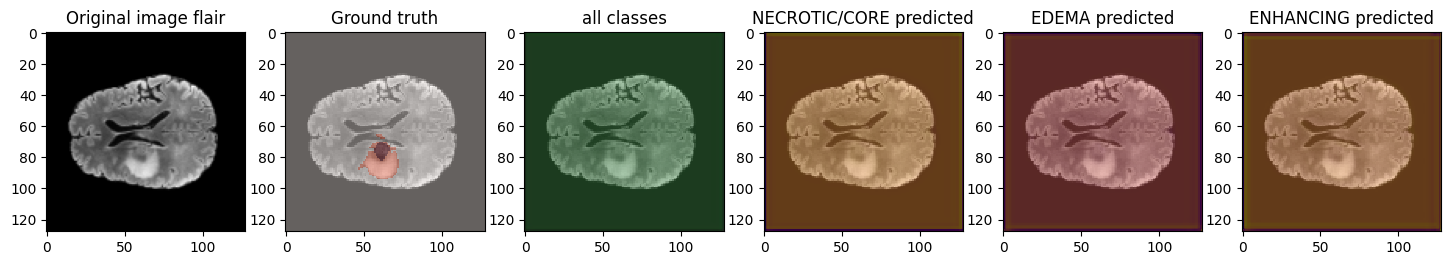

4/4 [==============================] - 0s 62ms/step


<Figure size 1800x5000 with 0 Axes>

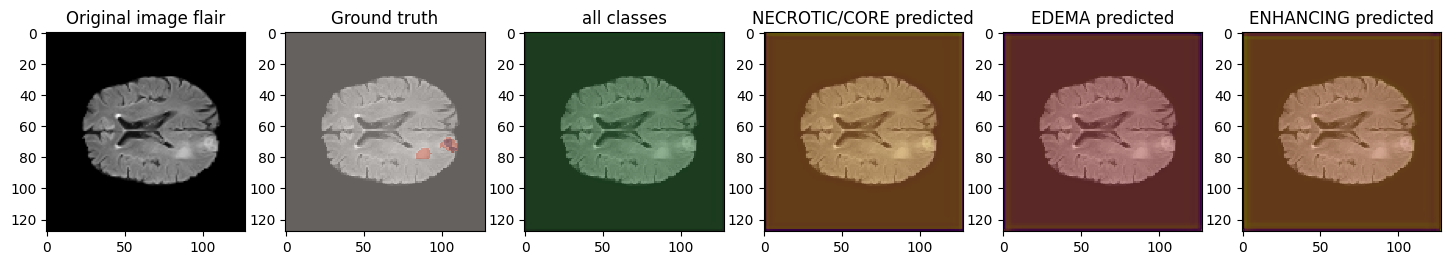

4/4 [==============================] - 0s 46ms/step


<Figure size 1800x5000 with 0 Axes>

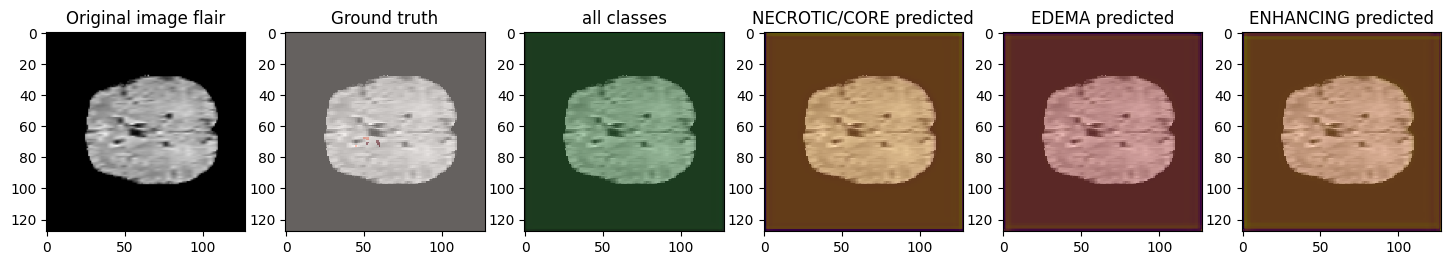

4/4 [==============================] - 0s 47ms/step


<Figure size 1800x5000 with 0 Axes>

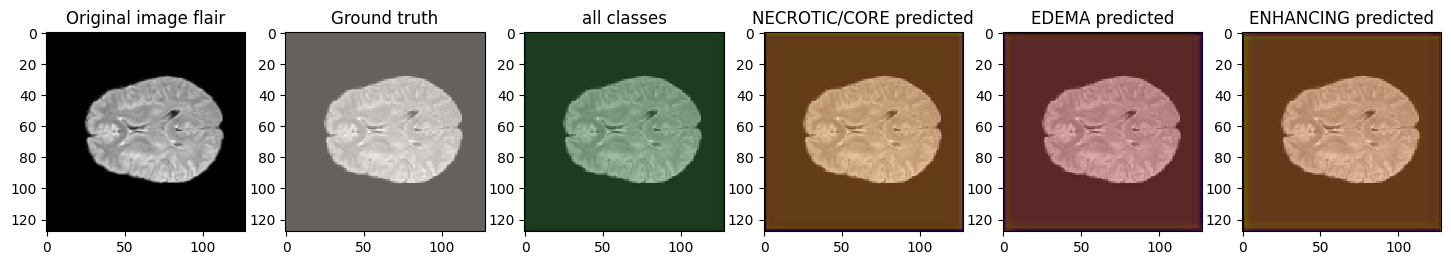

4/4 [==============================] - 0s 50ms/step


<Figure size 1800x5000 with 0 Axes>

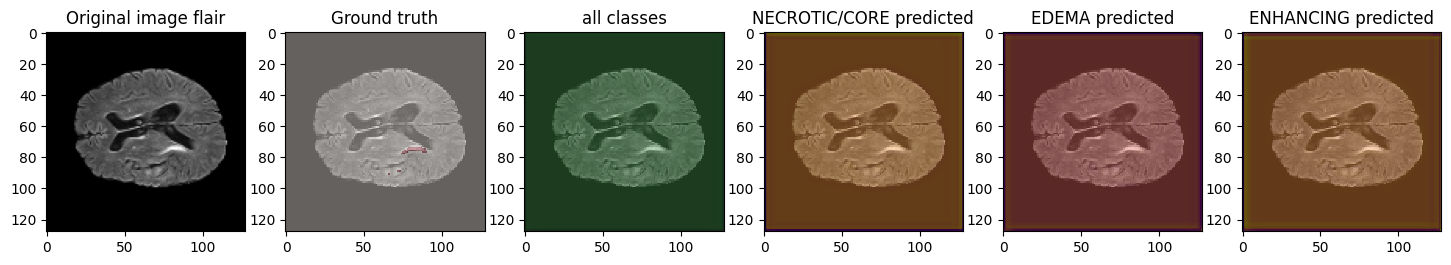

4/4 [==============================] - 0s 46ms/step


<Figure size 1800x5000 with 0 Axes>

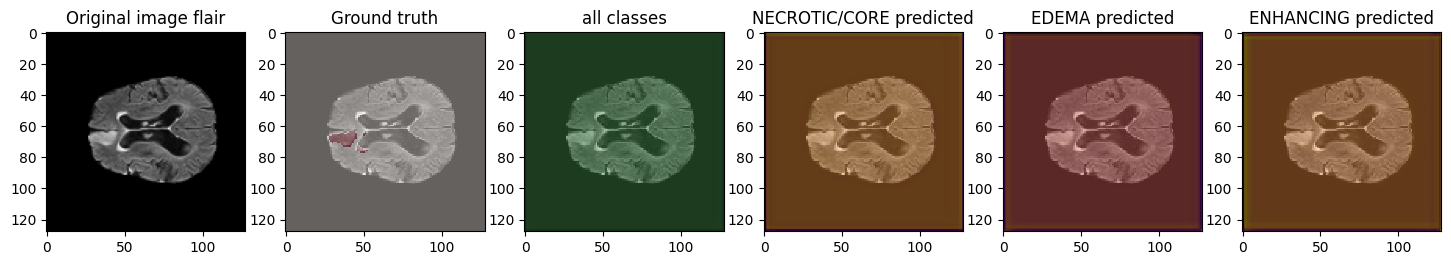

4/4 [==============================] - 0s 42ms/step


<Figure size 1800x5000 with 0 Axes>

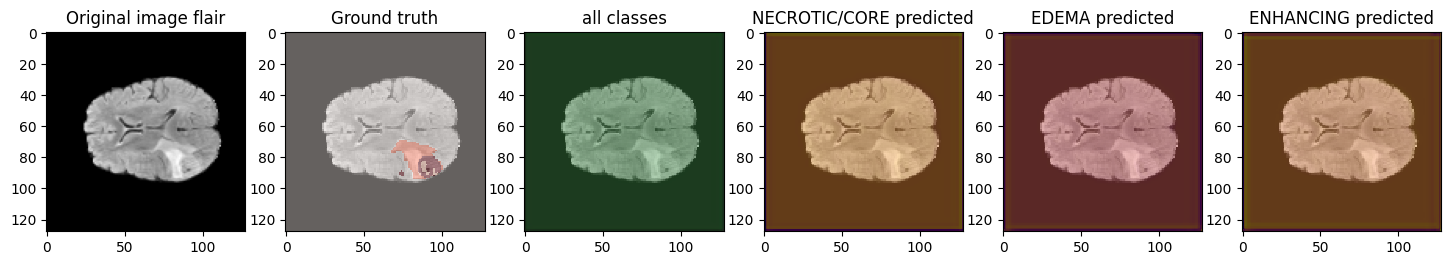

4/4 [==============================] - 0s 63ms/step


<Figure size 1800x5000 with 0 Axes>

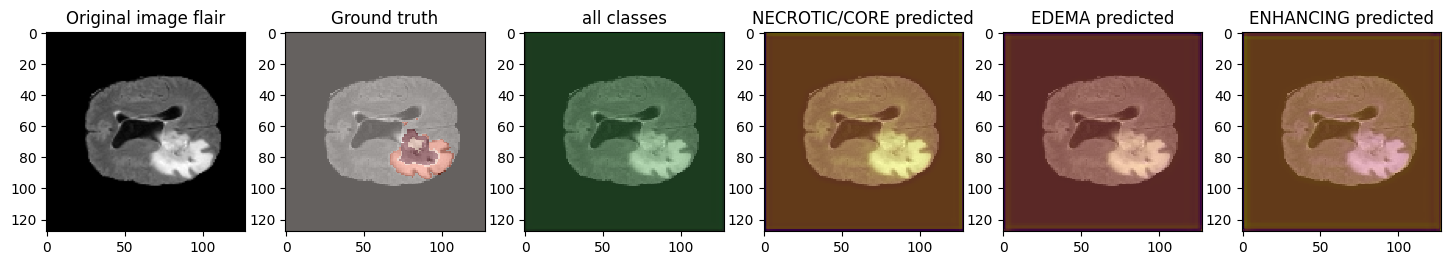

4/4 [==============================] - 0s 75ms/step


<Figure size 1800x5000 with 0 Axes>

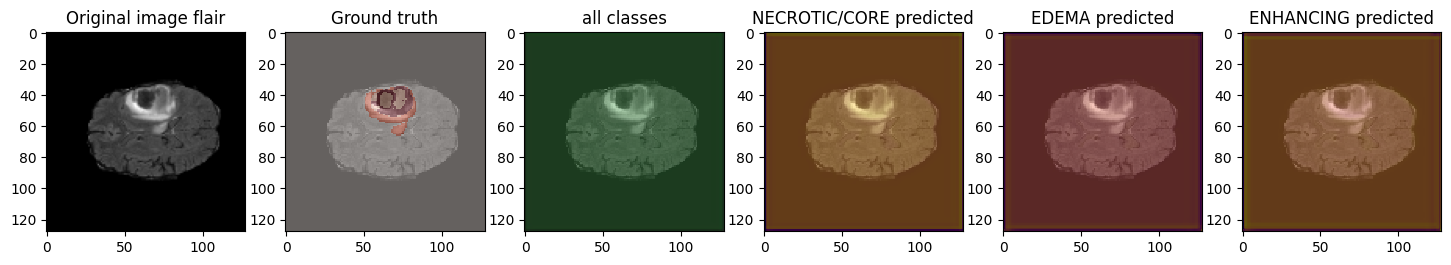

4/4 [==============================] - 0s 46ms/step


<Figure size 1800x5000 with 0 Axes>

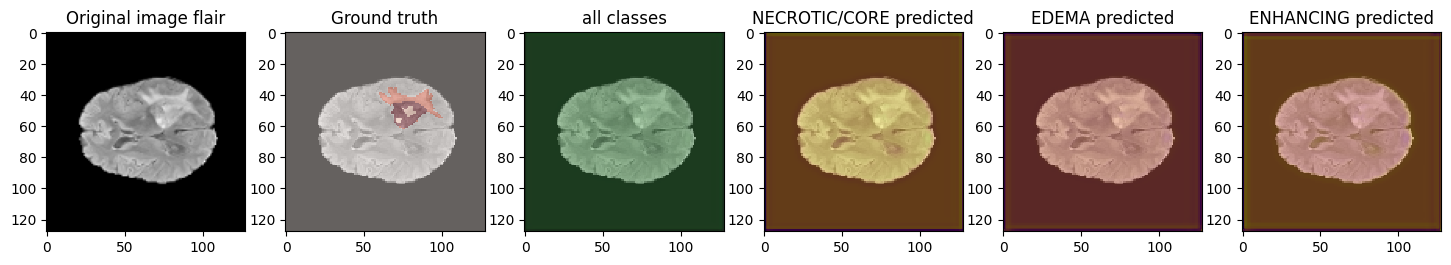

CPU times: user 1min 9s, sys: 5.38 s, total: 1min 14s
Wall time: 1min 9s


In [29]:
%%time
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))

   # /content/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_flair.nii

    #vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    vol_path = case_path + case + '_flair.nii.gz';
    flair=nib.load(vol_path).get_fdata()
    
    #vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    vol_path = case_path + case + '_t1ce.nii.gz';
    ce=nib.load(vol_path).get_fdata() 
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)

def showPredictsById(case, start_slice = 60):
    path = TRAIN_DATASET_PATH + case + '/'

    # TRAIN_DATASET_PATH + test_ids[0] + "/" + test_ids[0] + '_flair.nii'

    gt = nib.load(path + case +'_seg.nii.gz').get_fdata()
    origImage = nib.load(path + case +'_flair.nii.gz').get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='nearest', alpha=0.4) 
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Blues", interpolation='nearest', alpha=0.4)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="plasma", interpolation='nearest', alpha=0.4)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="plasma", interpolation='nearest', alpha=0.4)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="plasma", interpolation='nearest', alpha=0.4)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.savefig('Test_01.png')
    plt.show()
    
    
showPredictsById(case=test_ids[0])
showPredictsById(case=test_ids[1])
showPredictsById(case=test_ids[2])
showPredictsById(case=test_ids[3])
showPredictsById(case=test_ids[4])
showPredictsById(case=test_ids[5])
showPredictsById(case=test_ids[6])
showPredictsById(case=test_ids[7])
showPredictsById(case=test_ids[8])
showPredictsById(case=test_ids[9])
showPredictsById(case=test_ids[10])
showPredictsById(case=test_ids[11])
showPredictsById(case=test_ids[12])
showPredictsById(case=test_ids[13])
showPredictsById(case=test_ids[14])
showPredictsById(case=test_ids[15])
showPredictsById(case=test_ids[16])
showPredictsById(case=test_ids[17])
showPredictsById(case=test_ids[18])
showPredictsById(case=test_ids[19])
showPredictsById(case=test_ids[20])

4/4 [==============================] - 0s 59ms/step


<Figure size 640x480 with 0 Axes>

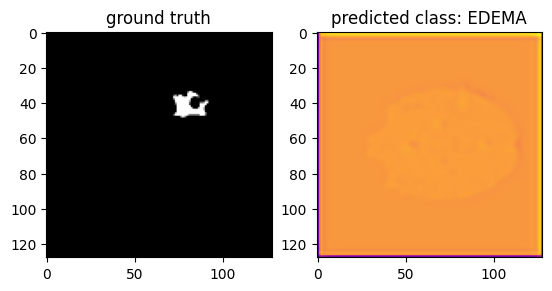

CPU times: user 1.19 s, sys: 214 ms, total: 1.4 s
Wall time: 1.26 s


In [40]:
%%time
case = test_ids[22]
# path = f"../input/brats2018-dataset/MICCAI_BraTS_2018_Data_Training/Brats18_{case}"
path = TRAIN_DATASET_PATH + case + "/" 
#gt = nib.load(path + test_ids[4] +'_seg.nii').get_fdata()
gt = nib.load(path + case +'_seg.nii.gz').get_fdata()
p = predictByPath(path,case)
core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]
i=40 # slice at
eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'

gt[gt != eval_class] = 1 # use only one class for per class evaluation 

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')

axarr[1].imshow(p[i,:,:,eval_class], cmap="plasma")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()